### Import Libraries

In [2]:
%pip install pywaffle pandas matplotlib seaborn tensorflow keras scikit-learn 

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [1]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #data viz
from matplotlib.gridspec import GridSpec #data viz
import seaborn as sns #data viz

from pywaffle import Waffle #data viz
from sklearn.compose import ColumnTransformer #data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler #data preprocessing
from sklearn.impute import KNNImputer #handle missing values
from imblearn.over_sampling import SMOTE #balance classes
from sklearn.model_selection import train_test_split #train/test dataset
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import layers, models #neural network architecture
from tensorflow.keras.callbacks import EarlyStopping #regularization
from tensorflow import keras #keras
import tensorflow as tf #tensorflow
from sklearn.metrics import accuracy_score, recall_score ,precision_score, f1_score, classification_report, confusion_matrix#evaluate model

ModuleNotFoundError: No module named 'sklearn'

### Read Dataset

In [49]:
#Read In Dataset
from google.colab import drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
stroke_data = pd.read_csv('/content/drive/MyDrive/healthcare-dataset-stroke-data.csv', index_col='id')
stroke_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data Preprocessing

In [50]:
#removes labels from dataset
X, y = stroke_data.drop('stroke', axis=1).values, stroke_data['stroke'].values

#Encodes catagoric variables
cat_ix = [0, 4, 5, 6, 9] #index of catagoric variables
cat_ct = ColumnTransformer([
    ('cat_vars', OneHotEncoder(), cat_ix)
], remainder='passthrough')
X_encoded = cat_ct.fit_transform(X)

#Impute missing values
#create KNN imputer object
knn_imp = KNNImputer(n_neighbors=5)
X_imputed = knn_imp.fit_transform(X_encoded)

#Scale Numeric Variables
num_ix = [16, 19, 20] #index of numeric variables
num_ct = ColumnTransformer([
    ('num_vars', StandardScaler(), num_ix)
], remainder='passthrough')
X_scaled = num_ct.fit_transform(X_imputed)

#displays scaled data
print('Example of Processed Data:')
print(X_scaled[0])

Example of Processed Data:
[1.05143428 2.70637544 0.98721932 0.         1.         0.
 0.         1.         0.         0.         1.         0.
 0.         0.         1.         0.         1.         0.
 0.         0.         1.        ]


In [51]:
#Splits the data into train, test, validate
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=8)

#displays the amount of samples in each dataset
print('Samples in Train Set:', len(X_train))
print('Samples in Validation Set:', len(X_val))
print('Samples in Test Set:', len(X_test))

Samples in Train Set: 3577
Samples in Validation Set: 766
Samples in Test Set: 767


In [52]:
#SMOTE for class balancing
sm = SMOTE(random_state=8)

#create new training set with SMOTE object
X_bal, y_bal = sm.fit_resample(X_train, y_train)

#Displays perccent of each class
print('Initial Dataset')
print('Percent "stroke":', y_train.sum()/len(y_train))
print('Balanced Dataset')
print('Percent "stroke":', y_bal.sum()/len(y_bal))

Initial Dataset
Percent "stroke": 0.048364551299972046
Balanced Dataset
Percent "stroke": 0.5


### Model Building: Neural Networks

In [53]:
#builds the architecture for a neural network
#creates a dense network with 1 skip step
inputs = keras.Input(shape=(21,))
a = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.6)(a)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.concatenate([a, x])
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(1, activation='sigmoid')(x)

nn = keras.Model(inputs, output, name="stroke_predictor")
nn.summary()

Model: "stroke_predictor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 dense_14 (Dense)            (None, 64)                   1408      ['input_3[0][0]']             
                                                                                                  
 dropout_12 (Dropout)        (None, 64)                   0         ['dense_14[0][0]']            
                                                                                                  
 dense_15 (Dense)            (None, 128)                  8320      ['dropout_12[0][0]']          
                                                                                   

In [54]:
#compiles the model with Adam optimizer
nn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy', metrics=['accuracy'])
early_stopper = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

#Trains the neural network
history = nn.fit(X_bal, y_bal, epochs=1000, callbacks=[early_stopper], validation_data=(X_val, y_val), verbose=0)

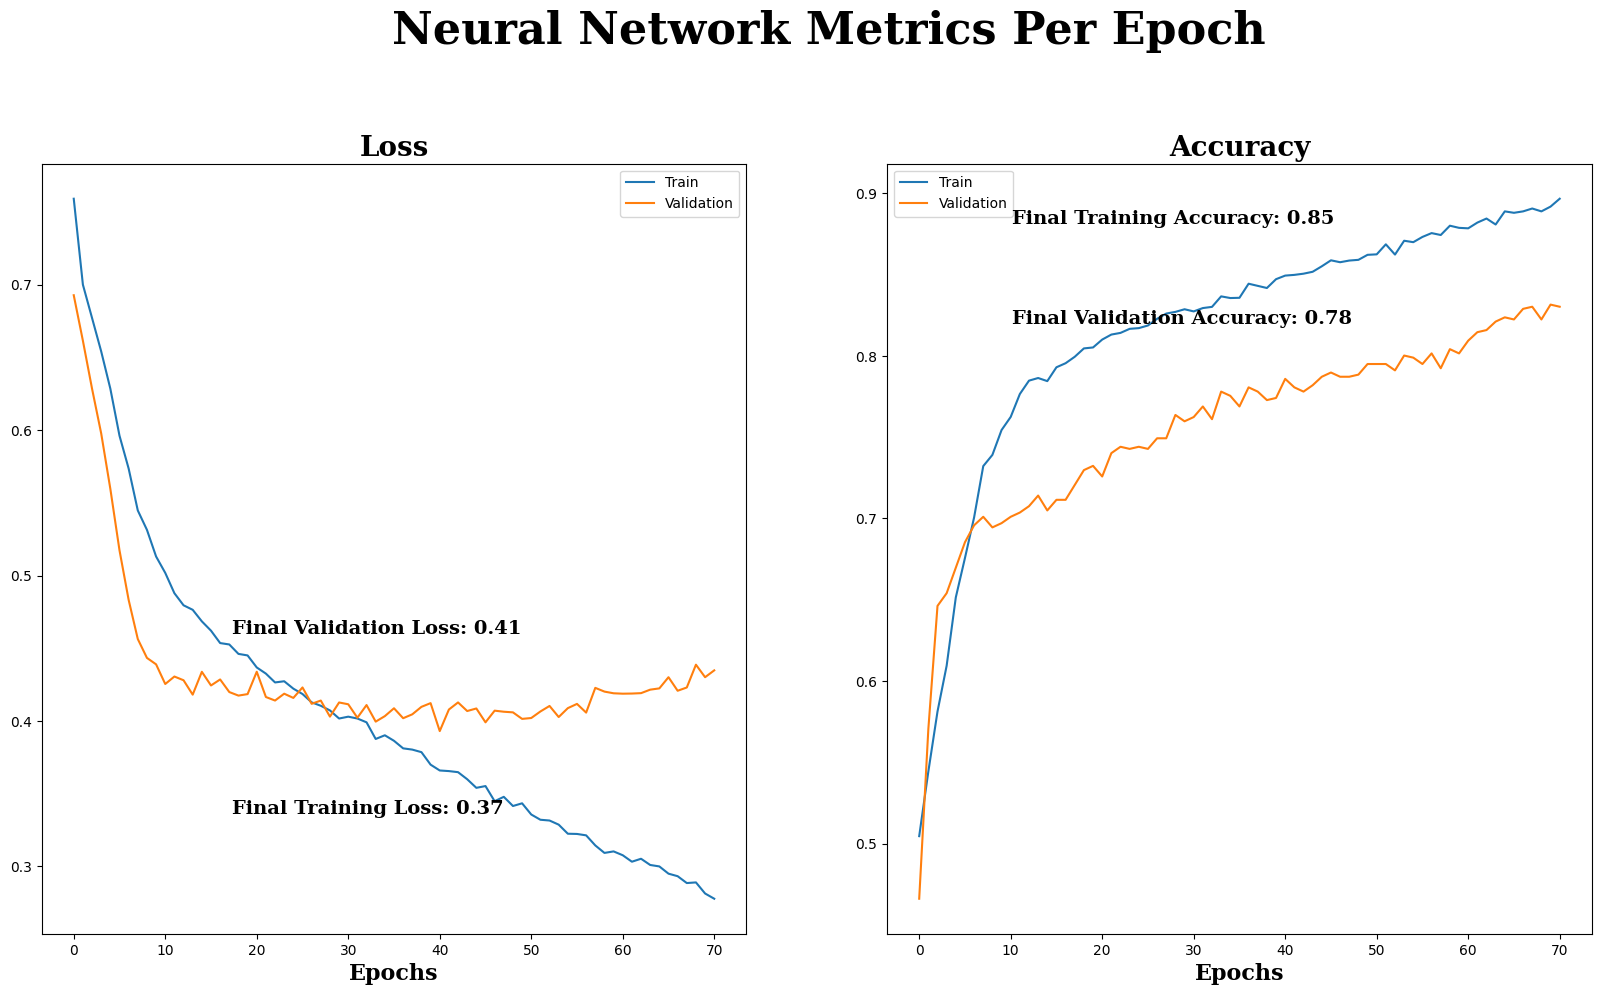

In [55]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']
min_val_loss = round(history.history['val_loss'][-30], 2)
min_train_loss = round(history.history['loss'][-30], 2)

val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']
max_val_acc = round(history.history['val_accuracy'][-30], 2)
max_train_acc = round(history.history['accuracy'][-30], 2)

#plots the training vs validation loss and accuracy
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax1.set_title('Loss', {'font':'Serif', 'fontsize':20,'fontweight':'bold', 'color':'black'})
ax1.set_xlabel('Epochs', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax1.plot(train_loss, label='Train')
ax1.plot(val_loss, label='Validation')
ax1.legend()
fig.text(0.22, 0.23, 'Final Training Loss: ' + str(min_train_loss),
         {'font':'Serif', 'fontsize':14,'fontweight':'bold', 'color':'black'})
fig.text(0.22, 0.41, 'Final Validation Loss: ' + str(min_val_loss),
         {'font':'Serif', 'fontsize':14,'fontweight':'bold', 'color':'black'})

ax2.set_title('Accuracy', {'font':'Serif', 'fontsize':20,'fontweight':'bold', 'color':'black'})
ax2.set_xlabel('Epochs', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax2.plot(train_acc, label='Train')
ax2.plot(val_acc, label='Validation')
ax2.legend()

fig.text(0.61, 0.82, 'Final Training Accuracy: ' + str(max_train_acc),
         {'font':'Serif', 'fontsize':14,'fontweight':'bold', 'color':'black'})
fig.text(0.61, 0.72, 'Final Validation Accuracy: ' + str(max_val_acc),
         {'font':'Serif', 'fontsize':14,'fontweight':'bold', 'color':'black'})

fig.text(0.3,1, 'Neural Network Metrics Per Epoch', {'font':'Serif', 'fontsize':32,'fontweight':'bold', 'color':'black'})
plt.show()

In [56]:
#Display the metrics of the neural network on the test set
test_preds = nn.predict(X_test)
threshold = 0.25
test_preds = [1. if i > threshold else 0. for i in test_preds]
test_acc = accuracy_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
test_pre = precision_score(y_test, test_preds)
print('Test Set Metrics')
print('Model Accuracy:', test_acc)
print('Model Recall:', test_rec)
print('Model Precision:', test_pre)

24/24 [==============================] - 0s 2ms/step
Test Set Metrics
Model Accuracy: 0.6792698826597132
Model Recall: 0.7435897435897436
Model Precision: 0.10943396226415095


### Model Building: KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn}")

print(classification_report(y_test, y_pred_knn))

Accuracy: 0.9478487614080835
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       728
           1       0.33      0.03      0.05        39

    accuracy                           0.95       767
   macro avg       0.64      0.51      0.51       767
weighted avg       0.92      0.95      0.93       767



### Model Building: SVM

In [58]:
model_svm = SVC(kernel = 'linear', random_state = 0)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

In [59]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(accuracy_svm)

0.9491525423728814


In [60]:
classification_rep_svm = classification_report(y_test, y_pred_svm)
print(classification_rep_svm)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       728
           1       0.00      0.00      0.00        39

    accuracy                           0.95       767
   macro avg       0.47      0.50      0.49       767
weighted avg       0.90      0.95      0.92       767



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model Building : Random Forest Classifier

In [61]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)
Y_pred_rf = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, Y_pred_rf)
confusion = confusion_matrix(y_test, Y_pred_rf)
classification_rep = classification_report(y_test, Y_pred_rf)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9478487614080835
Confusion Matrix:
 [[727   1]
 [ 39   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       728
           1       0.00      0.00      0.00        39

    accuracy                           0.95       767
   macro avg       0.47      0.50      0.49       767
weighted avg       0.90      0.95      0.92       767

